In [45]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
import pandas as pd
import torch
import transformers
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import sys
import scipy
from scipy.sparse import load_npz
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

In [47]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER = '/content/drive/MyDrive/CSC311/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
LEARNING_RATE = 0.0003
EMBEDDING_DIM = 128
INTERMEDIATE_DIM = 64
BATCH_SIZE = 320
NUM_HEADS = 8
MODEL_DEPTH = 6
DROPOUT = 0.05

# Loading Trianing data and preprocess

In [49]:
def _load_csv(path):
    # A helper function to load the csv file.
    if not os.path.exists(path):
        raise Exception("The specified path {} does not exist.".format(path))
    # Initialize the data.
    data = {
        "user_id": [],
        "question_id": [],
        "is_correct": []
    }
    # Iterate over the row to fill in the data.
    with open(path, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            try:
                data["question_id"].append(int(row[0]))
                data["user_id"].append(int(row[1]))
                data["is_correct"].append(int(row[2]))
            except ValueError:
                # Pass first row.
                pass
            except IndexError:
                # is_correct might not be available.
                pass
    return data

def load_train_csv(root_dir=FOLDER+"/data"):
    path = os.path.join(root_dir, "train_data.csv")
    return _load_csv(path)


def load_valid_csv(root_dir=FOLDER+"/data"):
    path = os.path.join(root_dir, "valid_data.csv")
    return _load_csv(path)

def load_public_test_csv(root_dir=FOLDER+"/data"):
    path = os.path.join(root_dir, "test_data.csv")
    return _load_csv(path)


def load_train_sparse(root_dir=FOLDER+"/data"):
    path = os.path.join(root_dir, "train_sparse.npz")
    if not os.path.exists(path):
        raise Exception("The specified path {} "
                        "does not exist.".format(os.path.abspath(path)))

    matrix = load_npz(path)
    return matrix

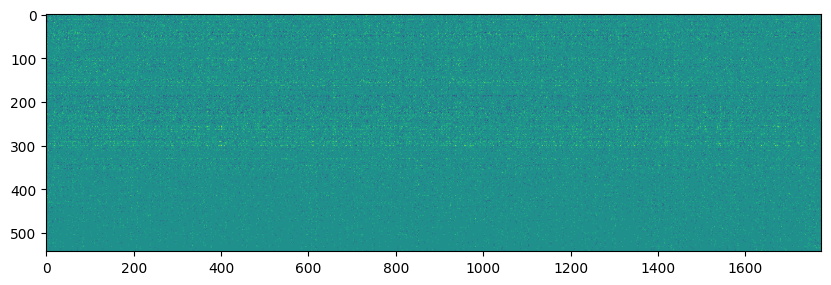

In [50]:
TRAIN_MAT = load_train_sparse().toarray()
TRAIN_MAT = np.nan_to_num(TRAIN_MAT, nan=-2)
TRAIN_MAT[TRAIN_MAT == 0] = -1
TRAIN_MAT[TRAIN_MAT == -2] = 0

plt.figure(figsize=(10, 6))
plt.imshow(TRAIN_MAT)
plt.show()

In [51]:
def preprocess(matrix):
    row_pos = {}
    row_neg = {}
    col_pos = {}
    col_neg = {}

    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value == 1:
                if j not in row_pos:
                    row_pos[j] = []
                row_pos[j].append(i)
                
                if i not in col_pos:
                    col_pos[i] = []
                col_pos[i].append(j)

            elif value == -1:
                if j not in row_neg:
                    row_neg[j] = []
                row_neg[j].append(i)
                
                if i not in col_neg:
                    col_neg[i] = []
                col_neg[i].append(j)

    return (row_pos, row_neg, col_pos, col_neg)

def get_all_relatives(coord, preprocessed_data_dict):
    row_pos, row_neg, col_pos, col_neg = preprocessed_data_dict
    i, j = coord
    if TRAIN_MAT[i, j] == 0:
      return None
    return (
        (row_pos.get(j, [])),
        (row_neg.get(j, [])),
        (col_pos.get(i, [])),
        (col_neg.get(i, [])),
    )


def get_all_relatives_numpy(coords, preprocessed_data, MAT=TRAIN_MAT):
    row_pos, row_neg, col_pos, col_neg = preprocessed_data

    row_pos_np = np.array([np.array(row_pos.get(j, []), dtype=int) for j in range(MAT.shape[1])], dtype=object)
    row_neg_np = np.array([np.array(row_neg.get(j, []), dtype=int) for j in range(MAT.shape[1])], dtype=object)
    col_pos_np = np.array([np.array(col_pos.get(i, []), dtype=int) for i in range(MAT.shape[0])], dtype=object)
    col_neg_np = np.array([np.array(col_neg.get(i, []), dtype=int) for i in range(MAT.shape[0])], dtype=object)

    i, j = coords.T
    mask = MAT[i, j] != 0
    valid_i, valid_j = i[mask], j[mask]

    results = (
        row_pos_np[valid_j],
        row_neg_np[valid_j],
        col_pos_np[valid_i],
        col_neg_np[valid_i],
    )

    return results


# Example usage

preprocessed_data_dict = preprocess(TRAIN_MAT)

In [52]:
print(get_all_relatives((1, 1), preprocessed_data_dict))
print([get_all_relatives_numpy(np.array([[1, 1], [2, 2]]), preprocessed_data_dict)[i][0].shape for i in range(4)])

([5, 63, 135, 190, 193, 211, 254, 262, 276, 281, 308, 312, 356, 483], [1, 46, 50, 102, 105, 264, 343, 349, 359, 391, 443, 451], [63, 101, 169, 195, 273, 311, 362, 377, 412, 469, 591, 601, 721, 724, 842, 909, 950, 979, 1021, 1088, 1128, 1190, 1209, 1359, 1361, 1378, 1415, 1432, 1540, 1575, 1629, 1634, 1715, 1757], [1, 35, 83, 189, 272, 400, 518, 620, 793, 846, 967, 1303, 1385, 1400, 1501, 1559, 1588, 1645])
[(14,), (12,), (34,), (18,)]


In [53]:
a = np.arange(0, 542)
b = np.arange(0, 1774)
grid = np.meshgrid(a, b)
matrix = np.column_stack((grid[0].flatten(), grid[1].flatten()))

output = get_all_relatives_numpy(matrix, preprocessed_data_dict)

In [54]:
row_pos, row_neg, col_pos, col_neg = output

In [55]:
rpm, rnm, cpm, cnm = [], [], [], []

# Iterate through each sublist in the nested list
for i in range(row_pos.shape[0]):
    # Append the length of the current sublist to the length_list
    rpm.append(len(row_pos[i]))
    rnm.append(len(row_neg[i]))
    cpm.append(len(col_pos[i]))
    cnm.append(len(col_neg[i]))

print(max(rpm), max(rnm), max(cpm), max(cnm))

50 35 421 331


# **Model**

In [56]:
import torch
import torch.nn as nn
from torch.nn import MultiheadAttention

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model=128, nhead=8, dropout=0.1, intermediate=64):
        super(Transformer, self).__init__()

        self.student_embed = nn.Linear(1774, d_model)
        self.question_embed = nn.Linear(768, d_model)

        # Create a stack of MultiheadAttention layers
        self.student_multihead_attn_layers = nn.ModuleList([MultiheadAttention(d_model, nhead, dropout=dropout) for _ in range(num_layers)])
        self.question_multihead_attn_layers = nn.ModuleList([MultiheadAttention(d_model, nhead, dropout=dropout) for _ in range(num_layers)])

        self.ff = nn.Sequential(nn.Linear(4 * d_model, intermediate), nn.ReLU(), nn.Linear(intermediate, 2), nn.Softmax(dim=1))

    def forward(self, student_pos, student_neg, question_pos, question_neg, question, student):

        # Embedding
        student_pos_embed = self.student_embed(student_pos)
        student_neg_embed = self.student_embed(student_neg) * -1
        question_pos_embed = self.question_embed(question_pos)
        question_neg_embed = self.question_embed(question_neg) * -1

        question_embed = self.question_embed(question)
        student_embed = self.student_embed(student)

        question_key_value = torch.cat((question_pos_embed, question_neg_embed), dim=1)
        student_key_value = torch.cat((student_pos_embed, student_neg_embed), dim=1)

        # Compute the attention using the question as the query and the other embeddings as key and value
        question_context_vector = question_embed.unsqueeze(1)
        student_context_vector = question_embed.unsqueeze(1)
        
        question_context_vector = question_context_vector.transpose(0, 1)
        question_key_value = question_key_value.transpose(0, 1)

        # Question cross attention
        for attn_layer in self.question_multihead_attn_layers:
            question_context_vector, _ = attn_layer(query=question_context_vector, 
                                                    key=question_key_value,
                                                    value=question_key_value)

        student_context_vector = student_context_vector.transpose(0, 1)
        student_key_value = student_key_value.transpose(0, 1)

        # Student cross attention
        for attn_layer in self.student_multihead_attn_layers:   
            student_context_vector, _ = attn_layer(query=student_context_vector, 
                                                    key=student_key_value,
                                                    value=student_key_value)

        question_context_vector = question_context_vector.squeeze(0)
        student_context_vector = student_context_vector.squeeze(0)

        combined_vector = torch.cat((question_context_vector, question_embed, student_context_vector, student_embed), dim=1)

        output = self.ff(combined_vector)
        return output


# Train & test

In [57]:
def tensor_from_arr(arrays, map, device):
    # Create a list of tensors from the nested numpy arrays
    tensor_list = [torch.tensor(map[subarray], dtype=torch.float32, device=device) for subarray in arrays]

    len = map[0].shape[0]

    # Get the lengths of the subarrays
    lengths = [(subarray.shape[0]) for subarray in arrays]

    # Calculate the maximum length
    max_length = max(lengths)

    # Pad the tensors and create a list of padded tensors
    padded_tensor_list = [torch.cat([tensor, torch.zeros((max_length - (tensor.shape[0]), len), device=device)]) for tensor in tensor_list]

    # Stack the padded tensors to create a tensor of shape (batchsize, max_length)
    result = torch.stack(padded_tensor_list)
    lengths = torch.tensor(lengths).to(device)

    return result, lengths

In [58]:
def train_epoch(model, QUESTION_EMBED, TRAIN_MAT, preprocessed_data_dict, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(data_loader, desc="Training"):
        student_ids = batch['user_id'].numpy().astype('int32')
        question_ids = batch['question_id'].numpy().astype('int32')
        labels = batch['is_correct'].long().to(device)


        coords = np.concatenate([student_ids.reshape(student_ids.shape[0], 1),
                                question_ids.reshape(question_ids.shape[0], 1)],
                                axis=1)

        rslt = get_all_relatives_numpy(coords, preprocessed_data_dict)

        student_pos_ids, student_neg_ids, question_pos_ids, question_neg_ids = rslt

        student_pos, student_pos_len = tensor_from_arr(student_pos_ids, TRAIN_MAT, device)
        student_neg, student_neg_len = tensor_from_arr(student_neg_ids, TRAIN_MAT, device)
        question_pos, question_pos_len = tensor_from_arr(question_pos_ids, QUESTION_EMBED, device)
        question_neg, question_neg_len = tensor_from_arr(question_neg_ids, QUESTION_EMBED, device)

        student_embedding = torch.tensor(TRAIN_MAT[student_ids], dtype=torch.float32).to(device)
        question_embedding = batch['question_embedding'].to(device)

        optimizer.zero_grad()
        logits = model(student_pos=student_pos, 
                       student_neg=student_neg, 
                       question_pos=question_pos, 
                       question_neg=question_neg, 
                       question=question_embedding, 
                       student=student_embedding).squeeze()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        torch.cuda.empty_cache() 

    return running_loss / len(data_loader)

In [59]:
def evaluate_with_acc(model, QUESTION_EMBED, TRAIN_MAT, VAL_MAT, preprocessed_val_dict, data_loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    FULL_MAT = np.clip(TRAIN_MAT + VAL_MAT, a_min=-1, a_max=1)
    
    with torch.no_grad():
        for batch in data_loader:
            student_ids = batch['user_id'].numpy().astype('int32')
            question_ids = batch['question_id'].numpy().astype('int32')
            labels = batch['is_correct'].long().to(device)


            coords = np.concatenate([student_ids.reshape(student_ids.shape[0], 1),
                                    question_ids.reshape(question_ids.shape[0], 1)],
                                    axis=1)

            rslt = get_all_relatives_numpy(coords, preprocessed_val_dict, MAT=FULL_MAT)

            student_pos_ids, student_neg_ids, question_pos_ids, question_neg_ids = rslt

            student_pos, student_pos_len = tensor_from_arr(student_pos_ids, TRAIN_MAT, device)
            student_neg, student_neg_len = tensor_from_arr(student_neg_ids, TRAIN_MAT, device)
            question_pos, question_pos_len = tensor_from_arr(question_pos_ids, QUESTION_EMBED, device)
            question_neg, question_neg_len = tensor_from_arr(question_neg_ids, QUESTION_EMBED, device)

            student_embedding = torch.tensor(TRAIN_MAT[student_ids], dtype=torch.float32).to(device)
            question_embedding = batch['question_embedding'].to(device)

            logits =  model(student_pos=student_pos, 
                            student_neg=student_neg, 
                            question_pos=question_pos, 
                            question_neg=question_neg, 
                            question=question_embedding, 
                            student=student_embedding).squeeze()

            loss = criterion(logits, labels)
            running_loss += loss.item()
            
            predictions = (logits[:, 0] < threshold).long()
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    return running_loss / len(data_loader), accuracy

# Data Loader

In [60]:
class ModelDataset(Dataset):
    def __init__(self, data, question_embeddings):
        self.user_ids = data['user_id']
        self.question_ids = data['question_id']
        self.is_correct = data['is_correct']
        self.question_embeddings = question_embeddings

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return {
            'user_id': self.user_ids[idx],
            'question_id': self.question_ids[idx],
            'question_embedding': self.question_embeddings[self.question_ids[idx]],
            'is_correct': self.is_correct[idx],
        }

In [61]:
train_data = load_train_csv()
val_data = load_valid_csv()
test_data = load_public_test_csv()

question_embeddings = np.load(FOLDER+'/data/extracted_feats_question_comp.npy')
QUESTION_EMBEDDING = question_embeddings

train_ds = ModelDataset(train_data, question_embeddings)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = ModelDataset(val_data, question_embeddings)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = ModelDataset(test_data, question_embeddings)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [62]:
def dict2matrix(data):
    user_ids = data['user_id']
    question_ids = data['question_id']
    is_correct = data['is_correct']

    matrix = np.zeros((np.max(user_ids) + 1, np.max(question_ids) + 1))
    matrix[:] = np.nan
    matrix[user_ids, question_ids] = is_correct
    return matrix

val_mat = dict2matrix(val_data)
val_mat = np.nan_to_num(val_mat, nan=-2)
val_mat[val_mat == 0] = -1
val_mat[val_mat == -2] = 0

test_mat = dict2matrix(test_data)
test_mat = np.nan_to_num(test_mat, nan=-2)
test_mat[test_mat == 0] = -1
test_mat[test_mat == -2] = 0

preprocessed_val_dict = preprocess(np.clip(TRAIN_MAT + val_mat, a_min=-1, a_max=1))
preprocessed_test_dict = preprocess(np.clip(TRAIN_MAT + test_mat, a_min=-1, a_max=1))

In [63]:
print(np.clip(TRAIN_MAT + val_mat, a_min=-1, a_max=1))
print(np.clip(TRAIN_MAT + test_mat, a_min=-1, a_max=1))

[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [64]:
transformer = Transformer(num_layers=MODEL_DEPTH, d_model=EMBEDDING_DIM, nhead=NUM_HEADS, dropout=DROPOUT, intermediate=INTERMEDIATE_DIM )

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [66]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)
transformer.to(device)

train_loss = 0.0

training_loss_epoch = []
validation_acc_epoch = []
final_test_acc = 0

# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss = train_epoch(transformer, 
                             QUESTION_EMBEDDING, 
                             TRAIN_MAT,
                             preprocessed_data_dict, 
                             train_dataloader, 
                             criterion, 
                             optimizer, 
                             device)
    
    val_loss, val_acc = evaluate_with_acc(transformer,
                                          QUESTION_EMBEDDING,
                                          TRAIN_MAT,
                                          val_mat,
                                          preprocessed_val_dict,
                                          val_dataloader,
                                          criterion,
                                          device)

    test_loss, test_acc = evaluate_with_acc(transformer,
                                            QUESTION_EMBEDDING,
                                            TRAIN_MAT,
                                            test_mat,
                                            preprocessed_test_dict,
                                            test_dataloader,
                                            criterion,
                                            device)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc:  {val_acc:.4f}'
          f', Test Loss: {test_loss:.4f}, Test Acc:  {test_acc:.4f}')
    training_loss_epoch.append(train_loss)
    validation_acc_epoch.append(val_acc)
    final_test_acc = test_acc

    torch.cuda.empty_cache()

Training: 100%|██████████| 178/178 [02:08<00:00,  1.38it/s]


Epoch 1/20, Train Loss: 0.6266, Validation Loss: 0.5975, Validation Acc:  0.6943, Test Loss: 0.5925, Test Acc:  0.6907


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 2/20, Train Loss: 0.5829, Validation Loss: 0.5819, Validation Acc:  0.7152, Test Loss: 0.5878, Test Acc:  0.7138


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 3/20, Train Loss: 0.5724, Validation Loss: 0.5812, Validation Acc:  0.7162, Test Loss: 0.5700, Test Acc:  0.7194


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 4/20, Train Loss: 0.5717, Validation Loss: 0.5701, Validation Acc:  0.7241, Test Loss: 0.5824, Test Acc:  0.7268


Training: 100%|██████████| 178/178 [02:01<00:00,  1.47it/s]


Epoch 5/20, Train Loss: 0.5701, Validation Loss: 0.5705, Validation Acc:  0.7245, Test Loss: 0.5792, Test Acc:  0.7197


Training: 100%|██████████| 178/178 [01:59<00:00,  1.48it/s]


Epoch 6/20, Train Loss: 0.5669, Validation Loss: 0.5812, Validation Acc:  0.7200, Test Loss: 0.5758, Test Acc:  0.7127


Training: 100%|██████████| 178/178 [02:04<00:00,  1.43it/s]


Epoch 7/20, Train Loss: 0.5670, Validation Loss: 0.5768, Validation Acc:  0.7178, Test Loss: 0.5745, Test Acc:  0.7217


Training: 100%|██████████| 178/178 [02:01<00:00,  1.47it/s]


Epoch 8/20, Train Loss: 0.5662, Validation Loss: 0.5704, Validation Acc:  0.7252, Test Loss: 0.5824, Test Acc:  0.7276


Training: 100%|██████████| 178/178 [02:02<00:00,  1.46it/s]


Epoch 9/20, Train Loss: 0.5636, Validation Loss: 0.5690, Validation Acc:  0.7244, Test Loss: 0.5717, Test Acc:  0.7240


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 10/20, Train Loss: 0.5624, Validation Loss: 0.5707, Validation Acc:  0.7251, Test Loss: 0.5616, Test Acc:  0.7288


Training: 100%|██████████| 178/178 [01:59<00:00,  1.49it/s]


Epoch 11/20, Train Loss: 0.5633, Validation Loss: 0.5703, Validation Acc:  0.7275, Test Loss: 0.5534, Test Acc:  0.7226


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 12/20, Train Loss: 0.5612, Validation Loss: 0.5695, Validation Acc:  0.7273, Test Loss: 0.5671, Test Acc:  0.7265


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 13/20, Train Loss: 0.5611, Validation Loss: 0.5697, Validation Acc:  0.7264, Test Loss: 0.5711, Test Acc:  0.7268


Training: 100%|██████████| 178/178 [01:59<00:00,  1.49it/s]


Epoch 14/20, Train Loss: 0.5589, Validation Loss: 0.5686, Validation Acc:  0.7283, Test Loss: 0.5613, Test Acc:  0.7276


Training: 100%|██████████| 178/178 [01:58<00:00,  1.50it/s]


Epoch 15/20, Train Loss: 0.5592, Validation Loss: 0.5714, Validation Acc:  0.7269, Test Loss: 0.5669, Test Acc:  0.7358


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 16/20, Train Loss: 0.5576, Validation Loss: 0.5707, Validation Acc:  0.7300, Test Loss: 0.5710, Test Acc:  0.7330


Training: 100%|██████████| 178/178 [01:59<00:00,  1.49it/s]


Epoch 17/20, Train Loss: 0.5596, Validation Loss: 0.5648, Validation Acc:  0.7310, Test Loss: 0.5634, Test Acc:  0.7310


Training: 100%|██████████| 178/178 [02:00<00:00,  1.48it/s]


Epoch 18/20, Train Loss: 0.5585, Validation Loss: 0.5701, Validation Acc:  0.7266, Test Loss: 0.5557, Test Acc:  0.7313


Training: 100%|██████████| 178/178 [01:58<00:00,  1.50it/s]


Epoch 19/20, Train Loss: 0.5569, Validation Loss: 0.5727, Validation Acc:  0.7252, Test Loss: 0.5657, Test Acc:  0.7316


Training: 100%|██████████| 178/178 [01:59<00:00,  1.49it/s]


Epoch 20/20, Train Loss: 0.5567, Validation Loss: 0.5675, Validation Acc:  0.7302, Test Loss: 0.5567, Test Acc:  0.7367


In [82]:
def visualize(lst1, lst2, entry1, entry2, file_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel(entry1)
    plt.title(f'{entry1} vs. Epoch with deep-attention model')
    plt.plot(lst1)

    plt.subplot(1, 2, 2)
    plt.title(f'{entry2} vs. Epoch with deep-attention model')
    plt.plot(lst2)
    plt.ylabel(entry2)
    plt.xlabel('Epoch')
    plt.savefig(f'{file_name}.jpg', dpi=400)
    plt.show()

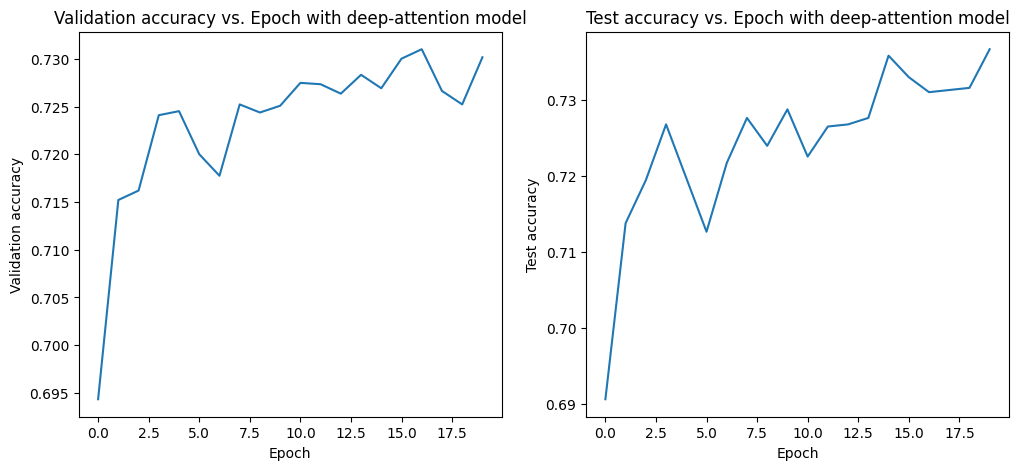

In [83]:
# Sorry I got it wrong
test_acc_epoch = training_loss_epoch
visualize(validation_acc_epoch, test_acc_epoch, 'Validation accuracy', 'Test accuracy', 'Accuracy_our')

In [84]:
train_loss = np.array([0.6266, 0.5829, 0.5724, 0.5717, 0.5701, 0.5669, 0.5670, 
                       0.5662, 0.5636, 0.5624, 0.5633, 0.5612, 0.5611, 0.5589, 
                       0.5592, 0.5576, 0.5596, 0.5585, 0.5569, 0.5567])

validation_loss = np.array([0.5975, 0.5819, 0.5812, 0.5701, 0.5705, 0.5812, 0.5768, 
                            0.5704, 0.5690, 0.5707, 0.5703, 0.5695, 0.5697, 0.5686,
                            0.5714, 0.5707, 0.5648, 0.5701, 0.5727, 0.5675,])

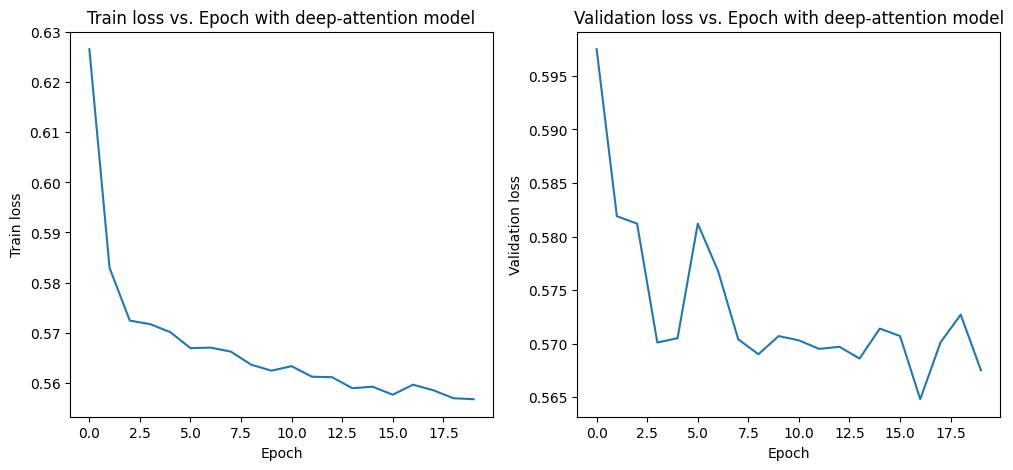

In [85]:
visualize(train_loss, validation_loss, 'Train loss', 'Validation loss', 'Loss_our')

In [86]:
print(validation_acc_epoch)
print(test_acc_epoch)

print(train_loss)
print(validation_loss)

[0.6943268416596104, 0.7152130962461191, 0.7162009596387242, 0.7241038667795653, 0.7245272368049676, 0.7200112898673441, 0.7177533163985323, 0.7252328535139713, 0.7243861134631668, 0.7250917301721704, 0.727490826982783, 0.7273497036409822, 0.7263618402483771, 0.7283375670335873, 0.72692633361558, 0.7300310471351962, 0.7310189105278013, 0.7266440869319786, 0.7252328535139713, 0.7301721704769969]
[0.6906576347727914, 0.7138018628281118, 0.7194467965001411, 0.7267852102737793, 0.7197290431837426, 0.7126728760937059, 0.7217047699689528, 0.7276319503245837, 0.7239627434377646, 0.7287609370589896, 0.7225515100197573, 0.7265029635901779, 0.7267852102737793, 0.7276319503245837, 0.7358171041490262, 0.7329946373130116, 0.7310189105278013, 0.7313011572114028, 0.7315834038950042, 0.7366638441998307]
[0.6266 0.5829 0.5724 0.5717 0.5701 0.5669 0.567  0.5662 0.5636 0.5624
 0.5633 0.5612 0.5611 0.5589 0.5592 0.5576 0.5596 0.5585 0.5569 0.5567]
[0.5975 0.5819 0.5812 0.5701 0.5705 0.5812 0.5768 0.5704 0